In [1]:
from src.model import VAE
from src.trainer import CDVAETrainer
from src.model import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2

In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [5]:
from src.utils import CMNISTGenerator, CMNIST

In [6]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11, device=device)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11, device=device)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [7]:
generator = CMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.3,
        corruptions.stripe: 0.2,
        corruptions.zigzag: 0.3,
        corruptions.canny_edges: 0.1,
        corruptions.brightness: 0.1
    },
)


In [8]:
dataset = CMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

test, train = random_split(dataset, [32, len(dataset) - 32])
valid, train = random_split(train, [10000, len(train) - 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:13<00:00, 4330.65item/s]


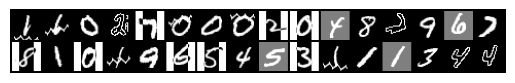

In [9]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)


X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


In [10]:
X.shape

torch.Size([32, 1, 28, 28])

### cosine sim + label-flipping

In [11]:
Z_DIM = 16
TEMP = 0.3
ALPHA = [100, 100]
LABEL_FLIPPING = True

In [12]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 0.5, "loc": 5e3, "scale": 1e3,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [13]:
next(iter(dataloader))[0].shape

torch.Size([128, 1, 28, 28])

In [14]:
trainer.fit(51, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 94.93it/s] 


val_recontr_loss=62.289, val_kl_c=3.831, val_kl_s=15.693, val_c_loss=0.494, val_s_loss=0.107
gMIG: 0.363


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 231.86it/s]


val_recontr_loss=28.926, val_kl_c=3.763, val_kl_s=9.015, val_c_loss=0.350, val_s_loss=0.107
gMIG: 0.455


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 210.92it/s]


val_recontr_loss=23.820, val_kl_c=3.107, val_kl_s=4.722, val_c_loss=0.328, val_s_loss=0.108
gMIG: 0.479


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 210.64it/s]


val_recontr_loss=21.920, val_kl_c=2.740, val_kl_s=3.331, val_c_loss=0.322, val_s_loss=0.108
gMIG: 0.481


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 206.09it/s]


val_recontr_loss=20.632, val_kl_c=2.623, val_kl_s=3.221, val_c_loss=0.313, val_s_loss=0.108
gMIG: 0.499


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 214.38it/s]


val_recontr_loss=19.819, val_kl_c=2.634, val_kl_s=3.157, val_c_loss=0.311, val_s_loss=0.108
gMIG: 0.498


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 220.44it/s]


val_recontr_loss=19.102, val_kl_c=2.693, val_kl_s=3.229, val_c_loss=0.311, val_s_loss=0.108
gMIG: 0.501


val-epoch 35: 100%|██████████| 79/79 [00:00<00:00, 228.96it/s]


val_recontr_loss=18.249, val_kl_c=2.697, val_kl_s=3.162, val_c_loss=0.313, val_s_loss=0.108
gMIG: 0.502


val-epoch 40: 100%|██████████| 79/79 [00:00<00:00, 221.23it/s]


val_recontr_loss=18.292, val_kl_c=2.737, val_kl_s=3.222, val_c_loss=0.316, val_s_loss=0.108
gMIG: 0.508


val-epoch 45: 100%|██████████| 79/79 [00:00<00:00, 199.19it/s]


val_recontr_loss=17.834, val_kl_c=2.724, val_kl_s=3.234, val_c_loss=0.313, val_s_loss=0.108
gMIG: 0.509


val-epoch 50: 100%|██████████| 79/79 [00:00<00:00, 228.34it/s]


val_recontr_loss=17.557, val_kl_c=2.738, val_kl_s=3.222, val_c_loss=0.314, val_s_loss=0.108
gMIG: 0.511


In [15]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

interpolate style:


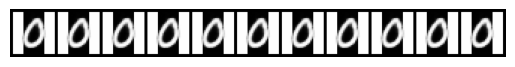

interpolate content:


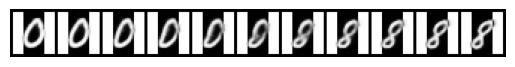

In [16]:
display_util(9, 16, z, vae, 16)

interpolate style:


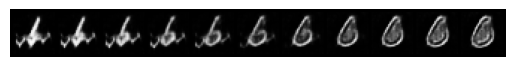

interpolate content:


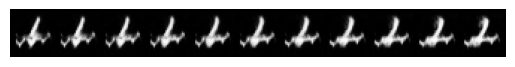

In [17]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

interpolate style:


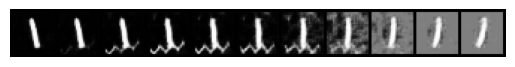

interpolate content:


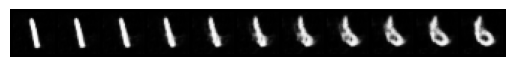

In [18]:
display_util(17, 14, z, vae, int(Z_DIM / 2))

interpolate style:


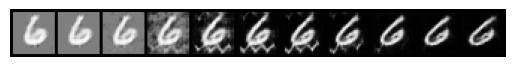

interpolate content:


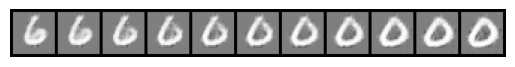

In [19]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

interpolate style:


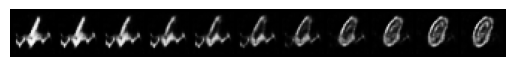

interpolate content:


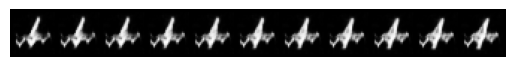

In [20]:
display_util(1, 31, z, vae, int(Z_DIM / 2))

In [21]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)


100%|██████████| 79/79 [00:00<00:00, 298.56it/s]


In [22]:
mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

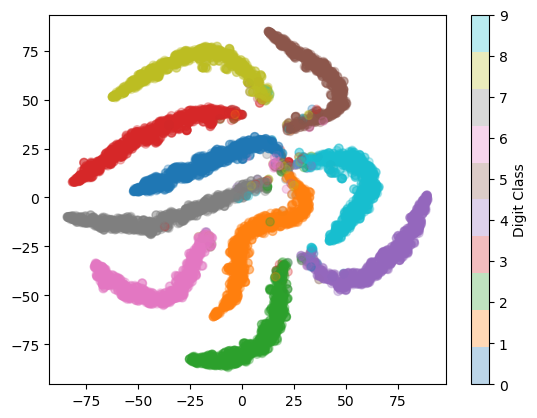

In [24]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

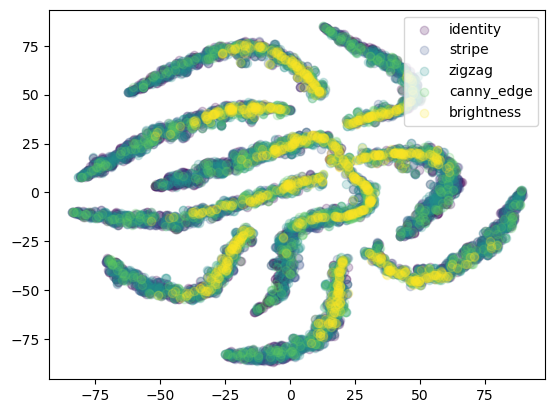

In [25]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [26]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

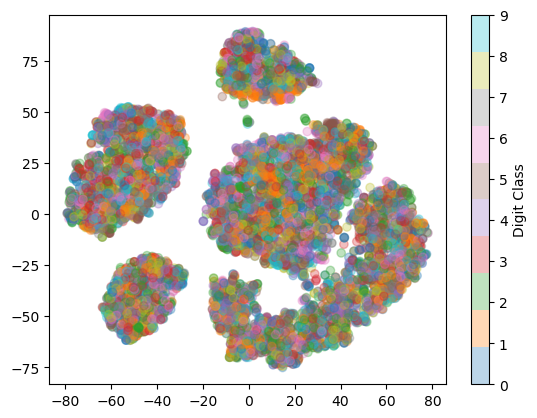

In [27]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

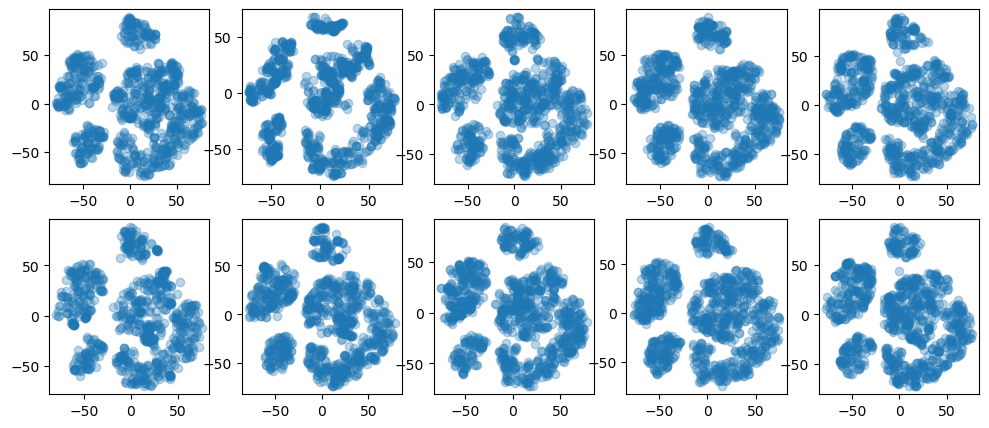

In [28]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

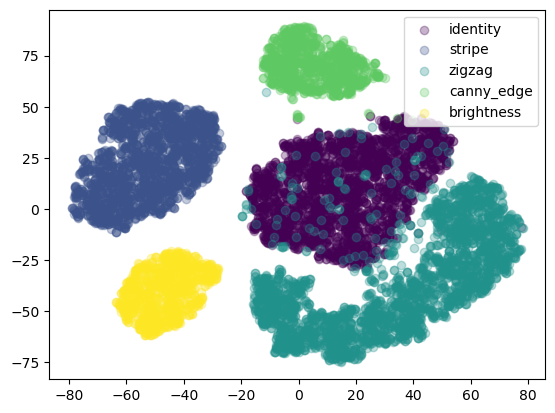

In [29]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

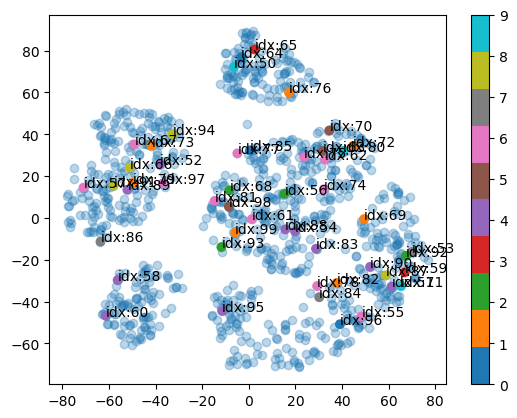

In [30]:
idxs = list(range(50, 100))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [31]:
idx = 8
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [32]:
for i in [53, 88, 62, 67, 73, 85, 79, 98, 68]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))

### cosine sim + (-L)

In [33]:
Z_DIM = 16
TEMP = 0.3
ALPHA = [100, 100]
LABEL_FLIPPING = False

In [34]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1, "loc": 5e3, "scale": 1e3,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=3,
    device=device,
)

In [35]:
trainer.fit(40, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 213.66it/s]


val_recontr_loss=49.981, val_kl_c=4.421, val_kl_s=14.872, val_c_loss=0.459, val_s_loss=-2.480
gMIG: 0.369


val-epoch 3: 100%|██████████| 79/79 [00:00<00:00, 228.92it/s]


val_recontr_loss=28.988, val_kl_c=4.352, val_kl_s=14.209, val_c_loss=0.346, val_s_loss=-2.478
gMIG: 0.448


val-epoch 6: 100%|██████████| 79/79 [00:00<00:00, 208.18it/s]


val_recontr_loss=26.690, val_kl_c=3.803, val_kl_s=8.572, val_c_loss=0.326, val_s_loss=-2.477
gMIG: 0.468


val-epoch 9: 100%|██████████| 79/79 [00:00<00:00, 219.68it/s]


val_recontr_loss=22.805, val_kl_c=3.096, val_kl_s=5.709, val_c_loss=0.317, val_s_loss=-2.478
gMIG: 0.473


val-epoch 12: 100%|██████████| 79/79 [00:00<00:00, 209.76it/s]


val_recontr_loss=22.221, val_kl_c=2.682, val_kl_s=4.111, val_c_loss=0.315, val_s_loss=-2.477
gMIG: 0.483


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 225.40it/s]


val_recontr_loss=21.874, val_kl_c=2.382, val_kl_s=3.745, val_c_loss=0.315, val_s_loss=-2.495
gMIG: 0.496


val-epoch 18: 100%|██████████| 79/79 [00:00<00:00, 219.18it/s]


val_recontr_loss=21.976, val_kl_c=2.151, val_kl_s=3.632, val_c_loss=0.313, val_s_loss=-2.499
gMIG: 0.493


val-epoch 21: 100%|██████████| 79/79 [00:00<00:00, 217.55it/s]


val_recontr_loss=21.432, val_kl_c=2.081, val_kl_s=3.644, val_c_loss=0.309, val_s_loss=-2.502
gMIG: 0.513


val-epoch 24: 100%|██████████| 79/79 [00:00<00:00, 217.35it/s]


val_recontr_loss=20.307, val_kl_c=2.067, val_kl_s=3.631, val_c_loss=0.309, val_s_loss=-2.502
gMIG: 0.517


val-epoch 27: 100%|██████████| 79/79 [00:00<00:00, 207.70it/s]


val_recontr_loss=20.375, val_kl_c=1.971, val_kl_s=3.546, val_c_loss=0.310, val_s_loss=-2.502
gMIG: 0.521


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 217.40it/s]


val_recontr_loss=19.599, val_kl_c=1.986, val_kl_s=3.657, val_c_loss=0.308, val_s_loss=-2.501
gMIG: 0.526


val-epoch 33: 100%|██████████| 79/79 [00:00<00:00, 219.97it/s]


val_recontr_loss=19.735, val_kl_c=1.970, val_kl_s=3.591, val_c_loss=0.307, val_s_loss=-2.502
gMIG: 0.535


val-epoch 36: 100%|██████████| 79/79 [00:00<00:00, 204.11it/s]


val_recontr_loss=19.397, val_kl_c=1.890, val_kl_s=3.543, val_c_loss=0.308, val_s_loss=-2.501
gMIG: 0.53


val-epoch 39: 100%|██████████| 79/79 [00:00<00:00, 200.23it/s]


val_recontr_loss=19.067, val_kl_c=1.911, val_kl_s=3.636, val_c_loss=0.309, val_s_loss=-2.502
gMIG: 0.533


In [36]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

interpolate style:


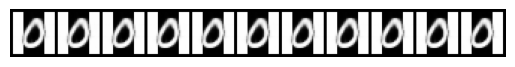

interpolate content:


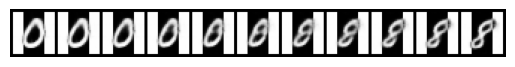

In [37]:
display_util(9, 16, z, vae, 16)

interpolate style:


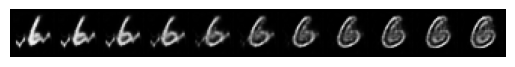

interpolate content:


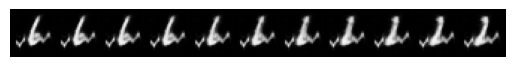

In [38]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

interpolate style:


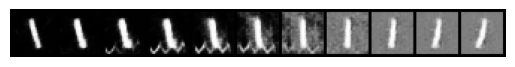

interpolate content:


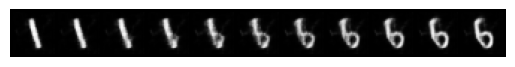

In [39]:
display_util(17, 14, z, vae, int(Z_DIM / 2))

interpolate style:


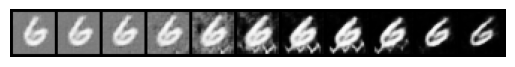

interpolate content:


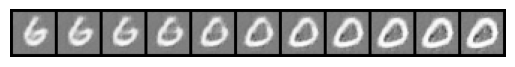

In [40]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

interpolate style:


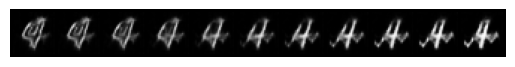

interpolate content:


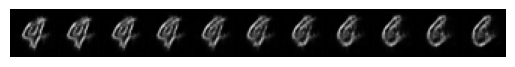

In [41]:
display_util(31, 1, z, vae, int(Z_DIM / 2))

In [42]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

100%|██████████| 79/79 [00:00<00:00, 358.43it/s]


In [43]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

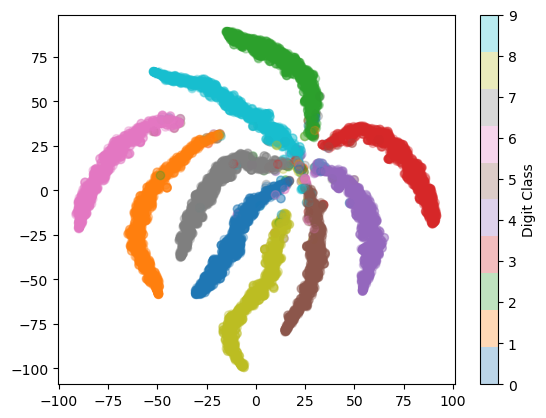

In [44]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

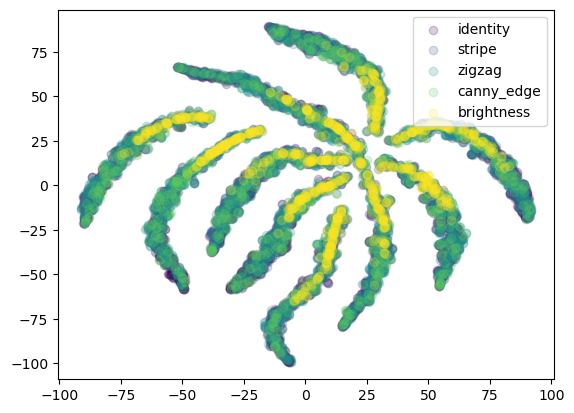

In [45]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [46]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

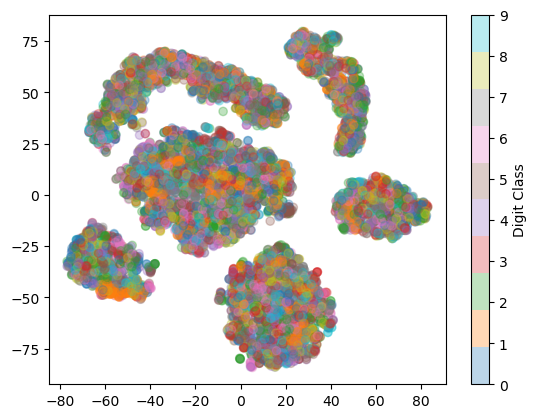

In [47]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

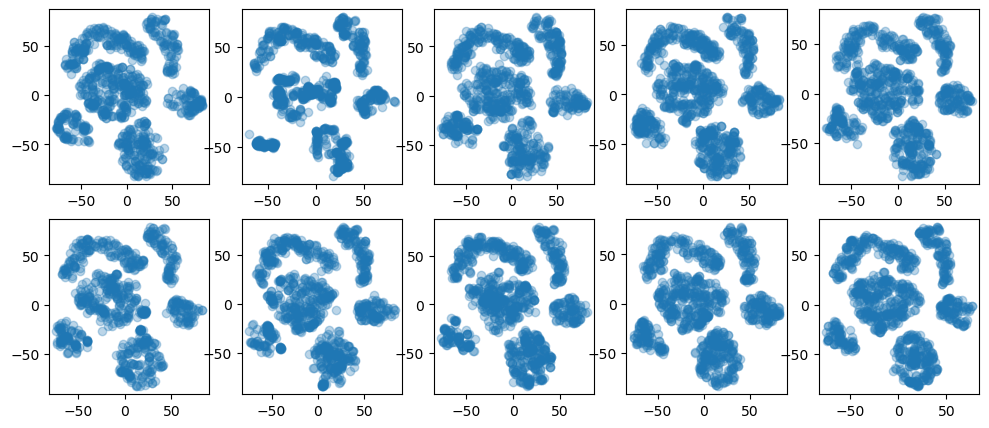

In [48]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

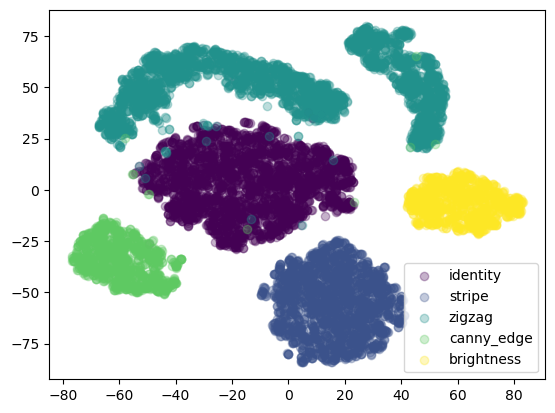

In [49]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

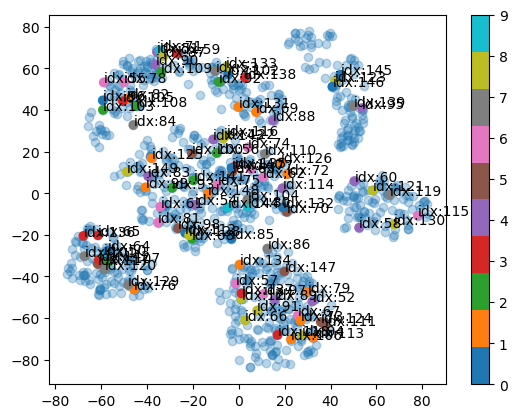

In [50]:
idxs = list(range(50, 150))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [51]:
idx = 8
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [52]:
for i in [53, 88, 62, 67, 73, 85, 79, 98, 68]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))